# XOR from scratch
The XOR problem with 5 inputs involves determining the output (0 or 1) based on 5 binary inputs. The output is 1 if the number of 1s in the inputs is odd, and 0 if it is even. The task is to create a model that predicts this output for all possible combinations of 5 binary inputs.

In [ ]:
#IMPORTS
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

###Description of the Dataset
First, lets implement the dataset for the XOR problem with 5 inputs. It's simply the set of all possible binary permutations with size of five. A permutation is an arrangement of *ones* and *zeros* in a specific order. To do this easily, we can make use of list comprehension. Since we are talking about binary permutations with five inputs, combinatoric gives us, that the count of our dataset must be equal to 2<sup>5</sup>


In [ ]:
def generate_binary_permutations(length=5):
    return [list(p) for p in product([0, 1], repeat=length)]

permutations = generate_binary_permutations() + generate_binary_permutations() + generate_binary_permutations()
assert len(permutations) == 3*2**5


To define the set of labels, we simply need to define a method, which decides  the problem for a specific input. Therefore, we use the mathematic definition of the problem for five inputs: If the sum of inputs is odd, return 1, else return 0.

In [ ]:
def xor_target_value(binary_list):
    return 1 if sum(binary_list) % 2 != 0 else 0

targets = [[xor_target_value(x)] for x in permutations]

### *Data Split*
Since we need to split the data, we can simply create a helper list, which contains indices, and then shuffle this list. Then take both, the inputs and the labels, and then shuffle both the same way.

In [ ]:
X = np.array(permutations)
y = np.array(targets)

np.random.seed(27)
indices = np.arange(len(X))
np.random.shuffle(indices)

split_index = int(0.8 * len(X))
train_indices = indices[:split_index]
test_indices = indices[split_index:]

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

Now let's define the *Neural Network's (NN's)* logic. Therefore a lot of helper functions are used.

## Activation
* ### *Sigmoid*
Sigmoid is the activation function within our *NN*. We use it to change(activate) the content of the *Neurons*.
* ### *Sigmoid derivative*
To update the *NN's* weights, we use the backpropagation algorithm, which is essentially just doing derivatives from the output to the input.

## Loss Functions
To make the *NN* learn, it looks at the training data and trys to decide the problem. To decide how good it's answer/output is, it uses an so called *Error Function (EF)*
To optimize the *NN*, two different *Loss-Functions* are implemented
* ### *Mean Squared Error (MSE)*
To make the *NN* learn, it looks at the training data and trys to decide the problem. To decide how good it's answer/output is, it uses an so called *Error Function (EF)*

* ### *Binary Cross Entropy (BCE)*

## Metrics
* ### *Accuracy*
The Accuracy is simply the fraction of correctly predicted samples by the total count of samples.
* ### *Loss*
Either the average Loss-Values of *MSE* or *BCE*

## Training Logic

In [ ]:
class MLP:
    def __init__(self, layer_sizes, learning_rate=0.01, loss_function="bce"):
        """
        Initialize a multi-layer perceptron with variable hidden layers.
        Args:
            layer_sizes: List of integers specifying the size of each layer.
            learning_rate: Learning rate for gradient descent.
            loss_function: The loss function to use ("bce" for Binary Cross-Entropy, "mse" for Mean Squared Error).
        """
        self.learning_rate = learning_rate
        self.layer_sizes = layer_sizes
        self.loss_function = loss_function.lower()  # Convert to lowercase for consistency

        # Initialize weights and biases
        self.weights = []
        self.biases = []

        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.1)
            self.biases.append(np.zeros((1, layer_sizes[i + 1])))

        # Metrics storage
        self.metrics = {
            "train_loss": [],
            "test_loss": [],
            "train_accuracy": [],
            "test_accuracy": [],
            "train_bad_facts": [],
            "test_bad_facts": [],
        }


    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def compute_loss(self, y_true, y_pred):
        if self.loss_function == "bce":
            # Binary Cross-Entropy Loss
            epsilon = 1e-8  # Prevent log(0)
            loss = -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))
        elif self.loss_function == "mse":
            # Mean Squared Error Loss
            loss = np.mean((y_pred - y_true) ** 2)
        else:
            raise ValueError(f"Unsupported loss function: {self.loss_function}")
        return loss

    def forward(self, X):
        self.activations = [X]  # Store activations of each layer
        self.z_values = []      # Store weighted sums (z) for each layer

        for w, b in zip(self.weights, self.biases):
            z = np.dot(self.activations[-1], w) + b
            self.z_values.append(z)
            self.activations.append(self.sigmoid(z))

        return self.activations[-1]

    def backward(self, y_true):
        gradients_w = [None] * len(self.weights)
        gradients_b = [None] * len(self.biases)

        if self.loss_function == "bce":
            # Error for BCE (sigmoid is derivative-friendly with BCE)
            delta = (self.activations[-1] - y_true) * self.sigmoid_derivative(self.z_values[-1])
        elif self.loss_function == "mse":
            # Error for MSE
            delta = 2 * (self.activations[-1] - y_true) * self.sigmoid_derivative(self.z_values[-1])

        # Gradients for the output layer
        gradients_w[-1] = np.dot(self.activations[-2].T, delta)
        gradients_b[-1] = np.sum(delta, axis=0, keepdims=True)

        # Backpropagate through hidden layers
        for l in range(len(self.weights) - 2, -1, -1):
            error = np.dot(delta, self.weights[l + 1].T)
            delta = error * self.sigmoid_derivative(self.z_values[l])

            gradients_w[l] = np.dot(self.activations[l].T, delta)
            gradients_b[l] = np.sum(delta, axis=0, keepdims=True)

        # Update weights and biases
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * gradients_w[i]
            self.biases[i] -= self.learning_rate * gradients_b[i]

    def train(self, X_train, y_train, X_test, y_test, epochs=1000):
        for epoch in range(epochs):
            # Forward pass on training data
            train_pred = self.forward(X_train)
            train_loss = self.compute_loss(y_train, train_pred)
            train_accuracy = self.compute_accuracy(y_train, train_pred)
            train_bad_facts = np.sum((train_pred > 0.5).astype(int) != y_train)

            # Backward pass for training data
            self.backward(y_train)

            # Forward pass on test data (no learning)
            test_pred = self.forward(X_test)
            test_loss = self.compute_loss(y_test, test_pred)
            test_accuracy = self.compute_accuracy(y_test, test_pred)
            test_bad_facts = np.sum((test_pred > 0.5).astype(int) != y_test)

            # Store metrics
            self.metrics["train_loss"].append(train_loss)
            self.metrics["test_loss"].append(test_loss)
            self.metrics["train_accuracy"].append(train_accuracy)
            self.metrics["test_accuracy"].append(test_accuracy)
            self.metrics["train_bad_facts"].append(train_bad_facts)
            self.metrics["test_bad_facts"].append(test_bad_facts)

    def compute_accuracy(self, y_true, y_pred):
        y_pred_binary = (y_pred > 0.5).astype(int)
        accuracy = np.mean(y_pred_binary == y_true)
        return accuracy

    def evaluate(self, X, y):
        predictions = self.forward(X)
        predictions_binary = (predictions > 0.5).astype(int)
        accuracy = np.mean(predictions_binary == y)
        return accuracy

    def plot_metrics(self):
        metrics_to_plot = {
            "Loss": ("train_loss", "test_loss"),
            "Accuracy": ("train_accuracy", "test_accuracy"),
            "Bad Facts": ("train_bad_facts", "test_bad_facts"),
        }

        plt.figure(figsize=(12, 3))
        for i, (title, (train_key, test_key)) in enumerate(metrics_to_plot.items(), 1):
            plt.subplot(1, len(metrics_to_plot), i)
            plt.plot(self.metrics[train_key], label=f"Train {title}", color="blue")
            plt.plot(self.metrics[test_key], label=f"Test {title}", color="orange")
            plt.title(f"{title} vs. Epochs")
            plt.xlabel("Epochs")
            plt.ylabel(title)
            plt.legend()

        plt.tight_layout()
        plt.show()

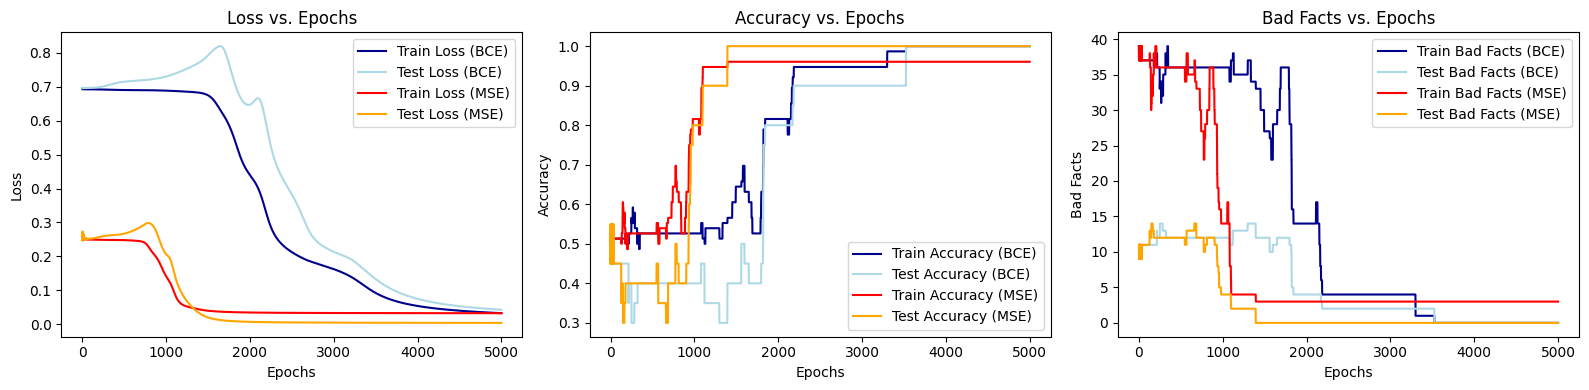

In [ ]:
# Train the models
mlp_bce = MLP(layer_sizes=[5, 5, 1], learning_rate=0.1, loss_function="bce")
mlp_bce.train(X_train, y_train, X_test, y_test, epochs=5000)

mlp_mse = MLP(layer_sizes=[5, 5, 1], learning_rate=0.1, loss_function="mse")
mlp_mse.train(X_train, y_train, X_test, y_test, epochs=5000)

# Plot combined metrics for both models
def plot_combined_metrics(model_bce, model_mse):
    metrics_to_plot = {
        "Loss": ("train_loss", "test_loss"),
        "Accuracy": ("train_accuracy", "test_accuracy"),
        "Bad Facts": ("train_bad_facts", "test_bad_facts"),
    }

    plt.figure(figsize=(16, 4))
    for i, (title, (train_key, test_key)) in enumerate(metrics_to_plot.items(), 1):
        plt.subplot(1, len(metrics_to_plot), i)

        # Plot BCE Metrics
        plt.plot(model_bce.metrics[train_key], label=f"Train {title} (BCE)", color="darkblue")
        plt.plot(model_bce.metrics[test_key], label=f"Test {title} (BCE)", color="lightblue")

        # Plot MSE Metrics
        plt.plot(model_mse.metrics[train_key], label=f"Train {title} (MSE)", color="red")
        plt.plot(model_mse.metrics[test_key], label=f"Test {title} (MSE)", color="orange")

        plt.title(f"{title} vs. Epochs")
        plt.xlabel("Epochs")
        plt.ylabel(title)
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plot combined metrics for both models (BCE and MSE)
plot_combined_metrics(mlp_bce, mlp_mse)
